In [74]:
import os, sys, glob, numpy as np, matplotlib, scipy
%matplotlib inline
from matplotlib import pyplot as plt
from numpy.random import poisson
from scipy import stats
from scipy.optimize import minimize

In [75]:
# Load in both the simulation and the data
sim = np.load("./data/IC86_2012_MC.npy")
data = np.load("./data/IC86_2012_exp.npy")

# Show the possible keys available here:
print("Keys available in simulation:")
print(sorted(sim.dtype.names))
print()

print("Keys available in data:")
print(sorted(data.dtype.names))

Keys available in simulation:
['angErr', 'azi', 'dec', 'event', 'logE', 'ow', 'ra', 'run', 'subevent', 'time', 'trueDec', 'trueE', 'trueRa', 'zen']

Keys available in data:
['angErr', 'azi', 'dec', 'event', 'logE', 'ra', 'run', 'subevent', 'time', 'zen']


In [76]:
# Also load in the "GoodRunList" (GRL), a file that tells
# us when the detector was taking good data. 
grl = np.load("./data/GRL/IC86_2012_exp.npy")

# Show the keys available in the GRL
print("Keys available in the GoodRunList:")
print(sorted(grl.dtype.names))

Keys available in the GoodRunList:
['events', 'livetime', 'run', 'start', 'stop']


In [77]:
# We will need the average rate for our analysis.
# We can get this by either counting the number of
# events in data or the number of events recorded
# in the GRL and dividing by the total good livetime.
total_events = len(data)
total_livetime = np.sum(grl['livetime'])

average_rate = total_events / total_livetime
print("Data has an average rate of {:4.2f} events/day".format(average_rate))

Data has an average rate of 339.96 events/day


In [78]:
# Define the parameters of our analysis.
# We're going to simplify things a little bit to start
# and ignore the impact of detector downtime, which
# would need to be included in an actual analysis.
# 
# Our first test analysis will look for an excess of 
# neutrino events in 1000 seconds centered on T=123.4
# using events from the entire sky.
analysis_time = 56123.4 # days
time_window = 1000 # seconds
time_window /= (24*3600.) # converted to days, since our rate is in days.

# We will be using the data to model the background in
# our test analysis. How many background events should
# we expect in our analysis?
n_expected = average_rate * time_window
print("We expect an average of {:4.3f} background events in our "\
      "{:4.3f} day time window.".format(n_expected, time_window))

We expect an average of 3.935 background events in our 0.012 day time window.


In [79]:
# Now that we have defined the parameters for our
# analysis, let's pick out the events that we want
# to focus on. 
# Define a function to pick out these events. For
# now, we'll only be applying this to data. Eventually,
# we'll also want to apply it to simulation as well
# once we have an analysis that eg only looks with 
# 2 degrees of a GRB or blazar position.
def select_events(dataset,
                  tstart = analysis_time-time_window/2.,
                  tend = analysis_time+time_window/2.):
    
    # Define the function here
    useful = (tstart <= dataset['time']) & (dataset['time'] < tend)
    events = dataset[useful]
    return events

selected_data = select_events(data)
print("Found {} events".format(len(selected_data)))

Found 4 events


In [80]:
# We will need to take data and get some "test statistic" 
# out of them. This will usually be a likelihood, but may
# include other things if required. If we use a likelihood,
# the "TS" value will typically be either the LLH or 2*LLH
def get_test_statistic(trial, 
                       n_background = n_expected,
                       n_signal = 0,
                       find_best_fit = True,
                       ):
    
    # Define the binned Poisson likelihood
    n_observed = len(trial)
    n_expected = n_background + n_signal

    # To better include the constants, we're going to
    # use the scipy.stats.poisson distribution code
    # directly. 
    nllh = -1 * stats.poisson.logpmf(n_observed, n_expected)
    return nllh

In [81]:
# The TS value we get from the above function is just
# a number. A number by itself doesn't tell us much
# and can't be used for actual physics. Instead, we
# need to learn how to interpret that number.
# Almost all analyses we do in IceCube include the
# concept of a "trial" to learn this interpretation
#
# A trial is one simulated observation. In our case,
# our analysis is looking at 1000 second time windows
# which may have signal and background events. Define
# a function which can produce a trial using simulation.
#
# We only care about the time window for now, so we 
# won't be using any directional information yet. 
# Note that the n_background and n_signal are the
# AVERAGE expectations, meaning that they do not have
# to be integers. You can have an *expectation* of 
# 0.5 events, but you cannot *observe* 0.5 events.
def produce_trial(simulation,
                  n_background = n_expected,
                  n_signal = 0.0):
    
    # Define the function here.
    number_bg = np.random.poisson(n_background)
    number_sig = np.random.poisson(n_signal)
    
    background_observed = np.random.choice(simulation, number_bg)
    signal_observed = np.random.choice(simulation, number_sig)

    #return the total number of events
    return np.concatenate([background_observed, signal_observed])

In [82]:
# Produce a single trial and calculate the TS value
# in order to test the functions.
trial_events = produce_trial(sim, n_signal=0)
trial_ts = get_test_statistic(trial_events, n_signal=0)
print(trial_ts)

1.6334153334500963


In [83]:
# We still don't know what this value actually means: it's
# just a number. In order to interpret the value, we need
# to know what we would expect from just background or 
# from signal+background. We do that by producing many
# trials and looking at the distribution of TS values.
# Write a function to make this simpler
def produce_trials(simulation, 
                   n_trials = 1000,
                   n_background = n_expected, 
                   n_signal_test = 0,
                   n_signal_injected = 0
                  ):
    ns = np.zeros(n_trials, dtype=float)
    ts = np.zeros(n_trials, dtype=float)
    for i in range(n_trials):
        trial_events = produce_trial(simulation, n_background, n_signal_injected)
        ts[i] = get_test_statistic(trial_events, n_background, n_signal_test)
        
    return ts


In [84]:
# Produce the TS values for a bunch of choices for signal
background_ts = produce_trials(sim, n_trials=10000)
signal_5_ts = produce_trials(sim, n_trials=10000, n_signal_test=0, n_signal_injected=5)
signal_10_ts = produce_trials(sim, n_trials=10000, n_signal_test=0, n_signal_injected=10)

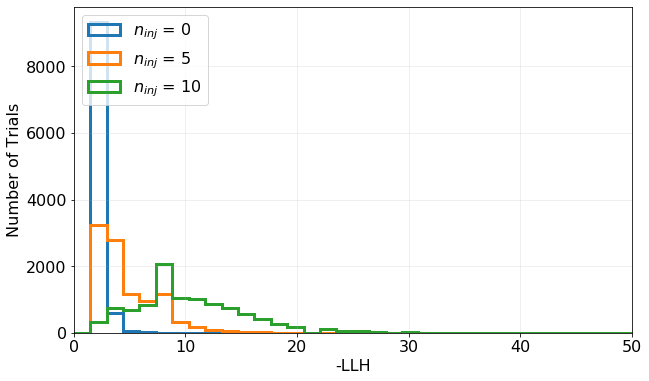

In [85]:
# And plot them all
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 50, 35)

ax.hist(background_ts,
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        label = r'$n_{inj}$ = 0')

ax.hist(signal_5_ts,
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        label = r'$n_{inj}$ = 5')

ax.hist(signal_10_ts,
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        label = r'$n_{inj}$ = 10')

ax.legend(loc='upper left', fontsize=16,)

ax.grid(alpha=0.25)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("-LLH", fontsize=16)
ax.set_ylabel("Number of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

In [86]:
# We've seen what the distributions looks like. 
# Let's calculate a "sensitivity". The sensitivity is
# used to estimate the amount of signal which can be
# hidden in the background and answers the following 
# question:
# What average number of signal events is required so
# that 90% of the (signal+background) distribution is
# above 50% of the (background only) distribution?
# 
# How can we answer this question?
# 
# Start by finding the median of the background distribution
# We do this by running "background trials": produce 100000
# samples of background. We're going to do this in a single
# cell so that we don't have to redo it later
background_ts = produce_trials(sim, n_trials=100000)

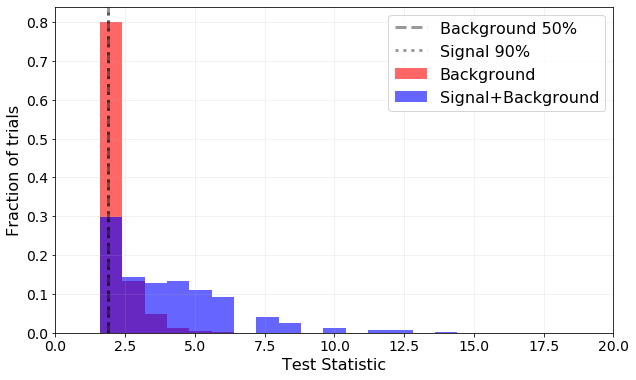

In [87]:
# Now pick a number of signal events and produce "signal trials"
# using the (signal+background) rate

# Now pick a number of signal events and produce "signal trials"
# using the (signal+background) rate
n_signal = 4.2
signal_ts = produce_trials(sim,
                           n_trials = 1000,
                           n_background = n_expected,
                           n_signal_injected = n_signal)

# Show these distributions to get a feel for how
# the two distributions look.
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.linspace(0, 20, 26)

_ = ax.hist(background_ts,
            bins = bins,
            weights = np.ones(len(background_ts), dtype=float)/len(background_ts),
            color = 'r',
            alpha = 0.6,
            label = 'Background')

_ = ax.hist(signal_ts,
            bins = bins,
            weights = np.ones(len(signal_ts), dtype=float)/len(signal_ts),
            color = 'b',
            alpha = 0.6,
            label = 'Signal+Background')

# Let's also directly show the location of the median 
# of the background distribution
background_median = np.percentile(background_ts, 50)
ax.axvline(background_median,
           linewidth=3,
           color = 'k',
           alpha = 0.4,
           linestyle = 'dashed',
           label = "Background 50%")

# We want 90% of the (signal+background) to be
# above the sensitivity, but np.percentile takes
# the percentage *below* instead.
signal_10pc = np.percentile(signal_ts, 100-90)
ax.axvline(signal_10pc,
           linewidth=3,
           color = 'k',
           alpha = 0.4,
           linestyle = 'dotted',
           label = "Signal 90%")


ax.legend(fontsize=16)
ax.grid(alpha=0.2)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("Test Statistic", fontsize=16)
ax.set_ylabel("Fraction of trials", fontsize=16,)
ax.tick_params(which="both", labelsize=14)

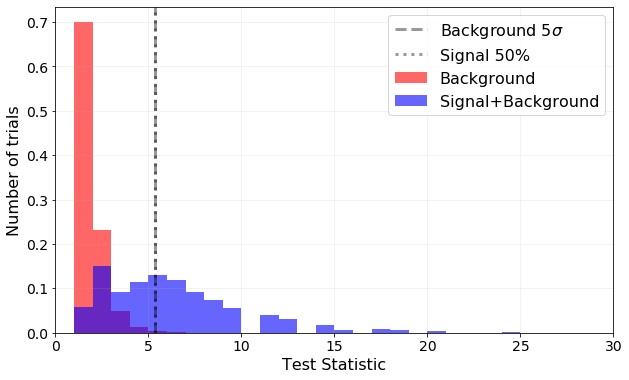

In [88]:
# In addition to the "sensitivity", there's also a
# "discovery potential". The discovery potential answers
# this question:
#
# How much signal is required to claim a discovery at N-sigma?
# 
# From a practical perspect, the process is almost identical 
# to that for the sensitivity. Here, we want to know what 
# signal is required for 50% of the (signal+background) distribution
# to be above N-sigma of the background distribution.
#
# Let's do this for a 3-sigma discovery
# 5-sigma corresponds to 99.73%

# Now pick a number of signal events and produce "signal trials"
# using the (signal+background) rate

# Now pick a number of signal events and produce "signal trials"
# using the (signal+background) rate
n_signal = 6.5
signal_ts = produce_trials(sim,
                           n_trials = 1000,
                           n_background = n_expected,
                           n_signal_injected = n_signal)

# Show these distributions to get a feel for how
# the two distributions look.
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.linspace(0, 30, 31)

_ = ax.hist(background_ts,
            bins = bins,
            weights = np.ones(len(background_ts), dtype=float)/len(background_ts),
            color = 'r',
            alpha = 0.6,
            label = 'Background')

_ = ax.hist(signal_ts,
            bins = bins,
            weights = np.ones(len(signal_ts), dtype=float)/len(signal_ts),
            color = 'b',
            alpha = 0.6,
            label = 'Signal+Background')

# Let's also directly show the location of the median 
# of the background distribution
background_median = np.percentile(background_ts, 99.73)
ax.axvline(background_median,
           linewidth=3,
           color = 'k',
           alpha = 0.4,
           linestyle = 'dashed',
           label = r"Background 5$\sigma$")

# We want 90% of the (signal+background) to be
# above the sensitivity, but np.percentile takes
# the percentage *below* instead.
signal_10pc = np.percentile(signal_ts, 50)
ax.axvline(signal_10pc,
           linewidth=3,
           color = 'k',
           alpha = 0.4,
           linestyle = 'dotted',
           label = "Signal 50%")


ax.legend(fontsize=16)
ax.grid(alpha=0.2)

ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("Test Statistic", fontsize=16)
ax.set_ylabel("Number of trials", fontsize=16,)
ax.tick_params(which="both", labelsize=14)